In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [29]:
df=pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [30]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [31]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [32]:
df.fillna(999, inplace=True)

In [33]:
def _assert_all_finite(X):
    """Like assert_all_finite, but only for ndarray."""
    X = np.asanyarray(X)
    # First try an O(n) time, O(1) space solution for the common case that
    # everything is finite; fall back to O(n) space np.isfinite to prevent
    # false positives from overflow in sum method.
    if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
            and not np.isfinite(X).all()):
        raise ValueError("Input contains NaN, infinity"
                         " or a value too large for %r." % X.dtype)

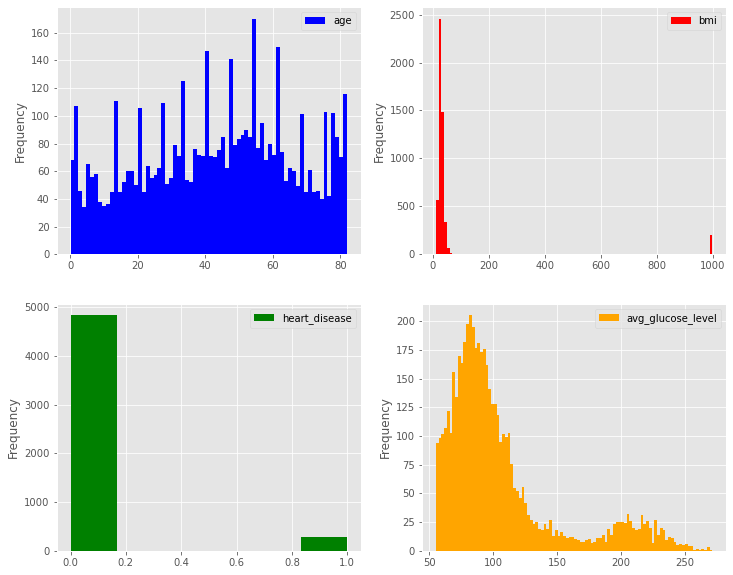

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
df.plot(kind="hist", y="age", bins=70, color="b", ax=axes[0][0])
df.plot(kind="hist", y="bmi", bins=100, color="r", ax=axes[0][1])
df.plot(kind="hist", y="heart_disease", bins=6, color="g", ax=axes[1][0])
df.plot(kind="hist", y="avg_glucose_level", bins=100, color="orange", ax=axes[1][1])
plt.show()

In [6]:
print ("Rows     : " , df.shape[0])
print ("Columns  : " , df.shape[1])
print ("\nFeatures : \n" , df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n",df.nunique())

Rows     :  5110
Columns  :  12

Features : 
 ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Missing values :   201

Unique values :  
 id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64


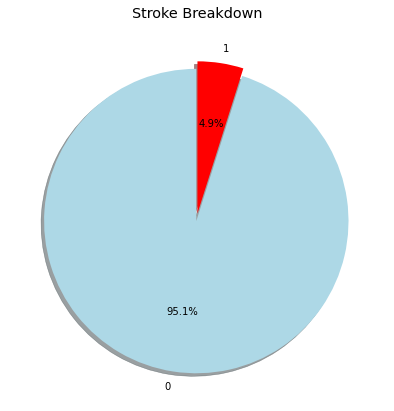

In [35]:
labels =df['stroke'].value_counts(sort = True).index
sizes = df['stroke'].value_counts(sort = True)
 
colors = ["lightblue","red"]
explode = (0.05,0) 
  
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)
 
plt.title('Stroke Breakdown')
plt.show()

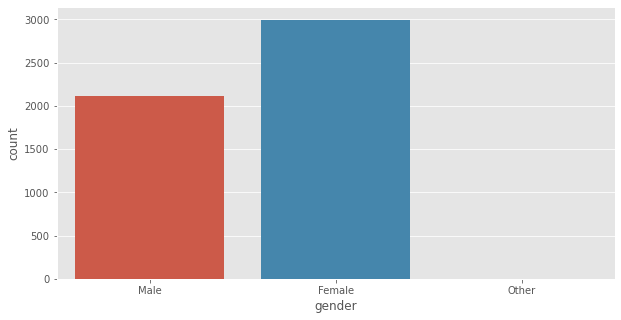

In [36]:
plt.figure(figsize=(10,5))
sns.countplot(data=df,x='gender');

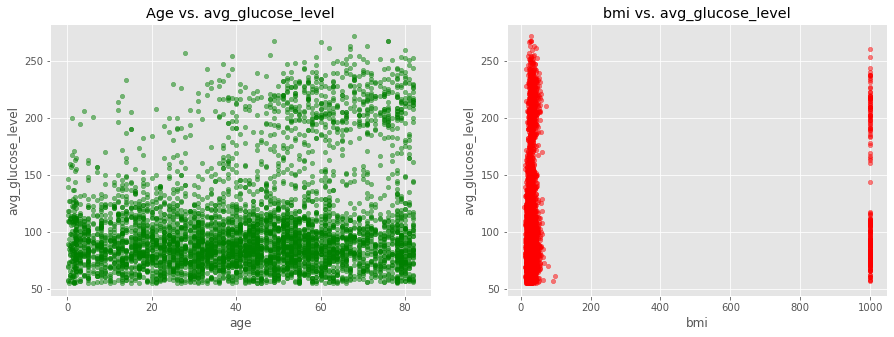

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df.plot(kind='scatter', x='age', y='avg_glucose_level', alpha=0.5, color='green', ax=axes[0], title="Age vs. avg_glucose_level")
df.plot(kind='scatter', x='bmi', y='avg_glucose_level', alpha=0.5, color='red', ax=axes[1], title="bmi vs. avg_glucose_level")
plt.show()

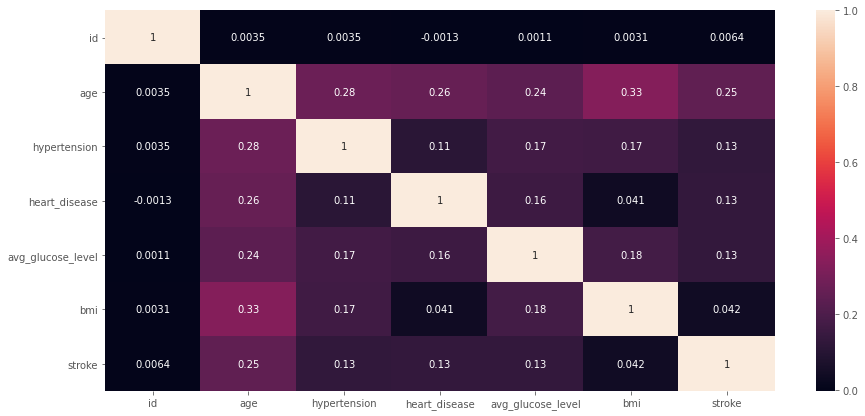

In [10]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True);

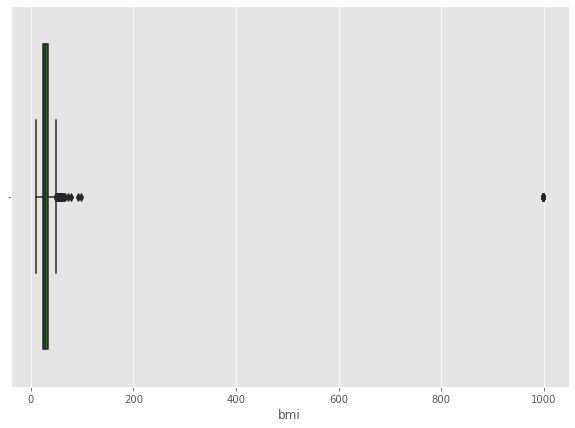

In [38]:
plt.figure(figsize=(10,7))
sns.boxplot(data=df,x=df["bmi"],color='green');

In [39]:
df["Residence_type"] = df["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)
df["ever_married"] = df["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)
df["gender"] = df["gender"].apply(lambda x: 1 if x=="Male" else 0)
 
  
df = pd.get_dummies(data=df, columns=['smoking_status'])
df = pd.get_dummies(data=df, columns=['work_type'])
df

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,9046,1,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,0,0,1,0,0
1,51676,0,61.0,0,0,1,0,202.21,999.0,1,0,0,1,0,0,0,0,1,0
2,31112,1,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,1,0,0
3,60182,0,49.0,0,0,1,1,171.23,34.4,1,0,0,0,1,0,0,1,0,0
4,1665,0,79.0,1,0,1,0,174.12,24.0,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,1,83.75,999.0,0,0,0,1,0,0,0,1,0,0
5106,44873,0,81.0,0,0,1,1,125.20,40.0,0,0,0,1,0,0,0,0,1,0
5107,19723,0,35.0,0,0,1,0,82.99,30.6,0,0,0,1,0,0,0,0,1,0
5108,37544,1,51.0,0,0,1,0,166.29,25.6,0,0,1,0,0,0,0,1,0,0


In [40]:
std=StandardScaler()
columns = ['avg_glucose_level','bmi','age']
scaled = std.fit_transform(df[['avg_glucose_level','bmi','age']])
scaled = pd.DataFrame(scaled,columns=columns)
df=df.drop(columns=columns,axis=1)
df=df.merge(scaled, left_index=True, right_index=True, how = "left")
df.head()

,id,gender,hypertension,heart_disease,ever_married,Residence_type,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,avg_glucose_level,bmi,age
0,9046,1,0,1,1,1,1,0,1,0,0,0,0,1,0,0,2.706375,-0.161347,1.051434
1,51676,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,2.121559,4.937840,0.786070
2,31112,1,0,1,1,0,1,0,0,1,0,0,0,1,0,0,-0.005028,-0.183071,1.626390
3,60182,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,1.437358,-0.173004,0.255342
4,1665,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1.501184,-0.228107,1.582163


In [41]:
df=df.drop(columns='id',axis=1)
df.head()

,gender,hypertension,heart_disease,ever_married,Residence_type,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,avg_glucose_level,bmi,age
0,1,0,1,1,1,1,0,1,0,0,0,0,1,0,0,2.706375,-0.161347,1.051434
1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,2.121559,4.937840,0.786070
2,1,0,1,1,0,1,0,0,1,0,0,0,1,0,0,-0.005028,-0.183071,1.626390
3,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,1.437358,-0.173004,0.255342
4,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1.501184,-0.228107,1.582163


In [25]:
df[df.isnull().any(axis=1)]

,gender,hypertension,heart_disease,ever_married,Residence_type,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,avg_glucose_level,bmi,age
1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,2.121559,NaN,0.786070
8,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,-0.662506,NaN,0.697615
13,1,0,1,1,1,1,1,0,0,0,0,0,1,0,0,2.510921,NaN,1.537935
19,1,0,1,0,1,1,1,0,0,0,1,0,0,0,0,2.449966,NaN,0.609161
27,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1.848364,NaN,0.653388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,-0.795017,NaN,-0.098477
5048,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1.877296,NaN,-0.142705
5093,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,-0.245757,NaN,0.078432
5099,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,-0.490462,NaN,-0.142705


In [42]:
X = df.drop(['stroke'], axis=1).values 
y = df['stroke'].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [45]:
#create adaboost classification obj
ab_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, learning_rate=0.5, random_state=100)
 
#training via adaboost classficiation model
ab_clf.fit(X_train, y_train)
print("training....\n")
 
#make prediction using the test set
ab_pred_stroke= ab_clf.predict(X_train)
print('prediction: \n', ab_pred_stroke)
 
print('\nparms: \n', ab_clf.get_params)
 
#score
ab_clf_score = ab_clf.score(X_test, y_test)
print("\nmean accuracy: %.2f" % ab_clf.score(X_test, y_test))

training....

prediction: 
 [0 0 0 ... 0 0 0]

parms: 
 <bound method BaseEstimator.get_params of AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.5,
                   n_estimators=100, random_state=100)>

mean accuracy: 0.90


Training Score 0.9619793122728544
Testing Score 
 0.9504240052185258
0.9504240052185258


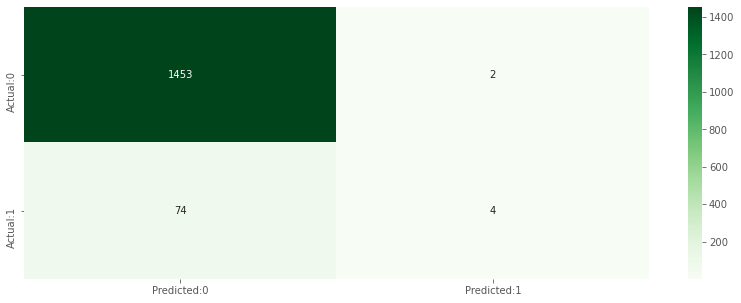

In [46]:
xgboost = GradientBoostingClassifier(random_state=0)
xgboost.fit(X_train, y_train)
#== 
#Score 
#== 
xgboost_score = xgboost.score(X_train, y_train)
xgboost_test = xgboost.score(X_test, y_test)
#== 
#testing model 
#== 
y_pred = xgboost.predict(X_test)
#== 
#evaluation
#== 
cm = confusion_matrix(y_test,y_pred)
print('Training Score',xgboost_score)
print('Testing Score \n',xgboost_test)
 
#=== 
#Confusion Matrix 
plt.figure(figsize=(14,5))
 
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="Greens");
print(accuracy_score(y_test,y_pred))

In [47]:
forest = RandomForestClassifier(n_estimators = 100)
#== 
forest.fit(X_train, y_train)
#== 
#Score 
#== 
forest_score = forest.score(X_train, y_train)
forest_test = forest.score(X_test, y_test)
#== 
#testing model 
#== 
y_pred = forest.predict(X_test)
#== 
#evaluation
#== 
cm = confusion_matrix(y_test,y_pred)
print('Training Score',forest_score)
print('Testing Score \n',forest_test)
print(cm)

Training Score 0.9997204361196533
Testing Score 
 0.9471624266144814
[[1451    4]
 [  77    1]]


In [49]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('stroke.png')
Image(graph.create_png())

NameError: name 'StringIO' is not defined

In [50]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [52]:
from sklearn import metrics

In [53]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.908675799086758
